In [ ]:
# ==================== 1. Setup ====================
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

# Parameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 8
EPOCHS = 150
START_INDEX = 0       # Start from 0
END_INDEX = 5000      # Use first 5000 images

# Paths
BLUR_PATH = "/content/drive/MyDrive/CelebAMask/lq"
CLEAR_PATH = "/content/drive/MyDrive/CelebAMask/hq"
GEN_SAVE_DIR = "/content/drive/MyDrive/models/generator_new"
DISC_SAVE_DIR = "/content/drive/MyDrive/models/discriminator_new"
SAMPLE_SAVE_DIR = "/content/drive/MyDrive/samples_new"

os.makedirs(GEN_SAVE_DIR, exist_ok=True)
os.makedirs(DISC_SAVE_DIR, exist_ok=True)
os.makedirs(SAMPLE_SAVE_DIR, exist_ok=True)

# ==================== 2. Data Loader ====================
def load_image_pair(blur_path, clear_path):
    blur_img = Image.open(blur_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert("RGB")
    clear_img = Image.open(clear_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert("RGB")
    blur_img = np.array(blur_img).astype(np.float32) / 127.5 - 1
    clear_img = np.array(clear_img).astype(np.float32) / 127.5 - 1
    return blur_img, clear_img

def load_dataset(blur_dir, clear_dir, start, end):
    blur_images = sorted(glob(os.path.join(blur_dir, "*.jpg")))[start:end]
    clear_images = sorted(glob(os.path.join(clear_dir, "*.jpg")))[start:end]

    blur_filenames = set([os.path.basename(f) for f in blur_images])
    clear_filenames = set([os.path.basename(f) for f in clear_images])
    common_filenames = list(blur_filenames.intersection(clear_filenames))

    blur_images_filtered = sorted([os.path.join(blur_dir, f) for f in common_filenames])
    clear_images_filtered = sorted([os.path.join(clear_dir, f) for f in common_filenames])

    dataset = tf.data.Dataset.from_tensor_slices((blur_images_filtered, clear_images_filtered))

    def map_fn(blur_path, clear_path):
        blur_img, clear_img = tf.numpy_function(
            load_image_pair, [blur_path, clear_path], [tf.float32, tf.float32]
        )
        blur_img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
        clear_img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
        return blur_img, clear_img

    return dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)\
                  .shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset = load_dataset(BLUR_PATH, CLEAR_PATH, start=START_INDEX, end=END_INDEX)

# ==================== 3. Define New Generator & Discriminator ====================
def build_generator():
    # Simple U-Net style generator
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu')(x)
    outputs = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(x)
    return tf.keras.Model(inputs, outputs)

def build_discriminator():
    inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='target_image')

    x = tf.keras.layers.Concatenate()([inp, tar])  # Conditional GAN
    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same', activation='relu')(x)
    outputs = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same')(x)

    return tf.keras.Model(inputs=[inp, tar], outputs=outputs)

generator = build_generator()
discriminator = build_discriminator()

# ==================== 4. Losses and Optimizers ====================
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    return gan_loss + 100 * l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + fake_loss

gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# ==================== 5. Training Step ====================
@tf.function
def train_step(input_img, target_img):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_img, training=True)
        disc_real_output = discriminator([input_img, target_img], training=True)
        disc_generated_output = discriminator([input_img, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target_img)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    gen_grad = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grad = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_grad, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_grad, discriminator.trainable_variables))

    return gen_loss, disc_loss

# ==================== 6. Training Loop with Metrics ====================
from tensorflow.image import psnr, ssim

def calculate_accuracy(y_true, y_pred, threshold=0.1):
    diff = tf.abs(y_true - y_pred)
    correct_pixels = tf.reduce_sum(tf.cast(diff < threshold, tf.float32))
    total_pixels = tf.cast(tf.size(diff), tf.float32)
    return correct_pixels / total_pixels

g_losses, d_losses = [], []
ssim_scores, psnr_scores, acc_scores, metric_epochs = [], [], [], []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    epoch_g_loss, epoch_d_loss = 0, 0
    steps = 0

    for step, (blur_img, clear_img) in enumerate(train_dataset):
        g_loss, d_loss = train_step(blur_img, clear_img)
        epoch_g_loss += g_loss.numpy()
        epoch_d_loss += d_loss.numpy()
        steps += 1

    epoch_g_loss /= steps
    epoch_d_loss /= steps
    g_losses.append(epoch_g_loss)
    d_losses.append(epoch_d_loss)

    print(f"  Generator Loss: {epoch_g_loss:.4f} | Discriminator Loss: {epoch_d_loss:.4f}")

    # ---- Generate sample & metrics every 10 epochs ----
    if (epoch + 1) % 10 == 0:
        for input_img, target_img in train_dataset.take(1):
            pred = generator(input_img, training=False)
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            for i, img in enumerate([input_img[0], target_img[0], pred[0]]):
                axs[i].imshow((img + 1) / 2)
                axs[i].axis('off')
                axs[i].set_title(['Blurred', 'Clear', 'Generated'][i])
            plt.savefig(f"{SAMPLE_SAVE_DIR}/sample_epoch_{epoch+1}.png")
            plt.close()

        # Calculate metrics
        for input_img, target_img in train_dataset.take(1):
            gen_img = generator(input_img, training=False)
            ssim_score = tf.reduce_mean(ssim((target_img+1)*127.5, (gen_img+1)*127.5, max_val=255.0)).numpy()
            psnr_score = tf.reduce_mean(psnr((target_img+1)*127.5, (gen_img+1)*127.5, max_val=255.0)).numpy()
            acc_score = calculate_accuracy(target_img, gen_img).numpy()

            ssim_scores.append(ssim_score)
            psnr_scores.append(psnr_score)
            acc_scores.append(acc_score)
            metric_epochs.append(epoch + 1)

            print(f"📊 [Epoch {epoch+1}] SSIM: {ssim_score:.4f}, PSNR: {psnr_score:.2f} dB, Accuracy: {acc_score*100:.2f}%")

    # ---- Save models every 50 epochs ----
    if (epoch + 1) % 50 == 0:
        generator.save(os.path.join(GEN_SAVE_DIR, f"generator_epoch_{epoch+1}.keras"))
        discriminator.save(os.path.join(DISC_SAVE_DIR, f"discriminator_epoch_{epoch+1}.keras"))
        print(f"💾 Models saved at epoch {epoch+1}")

# ==================== 7. Final Save & Graphs ====================
generator.save(os.path.join(GEN_SAVE_DIR, "generator_final.keras"))
discriminator.save(os.path.join(DISC_SAVE_DIR, "discriminator_final.keras"))
print("\n✅ Final models saved successfully!")

plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss", color='blue')
plt.plot(d_losses, label="Discriminator Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(SAMPLE_SAVE_DIR, "loss_graph.png"))
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(metric_epochs, ssim_scores, label="SSIM", marker='o')
plt.plot(metric_epochs, psnr_scores, label="PSNR", marker='x')
plt.plot(metric_epochs, [a*100 for a in acc_scores], label="Accuracy (%)", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Evaluation Metrics Over Epochs")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(SAMPLE_SAVE_DIR, "metric_graph.png"))
plt.close()

print("📈 Graphs saved: loss_graph.png and metric_graph.png")



Epoch 1/150


✅ Models loaded successfully!
Testing on: 21392.jpg
PSNR: 27.68 dB
SSIM: 0.8363
Accuracy: 86.98%


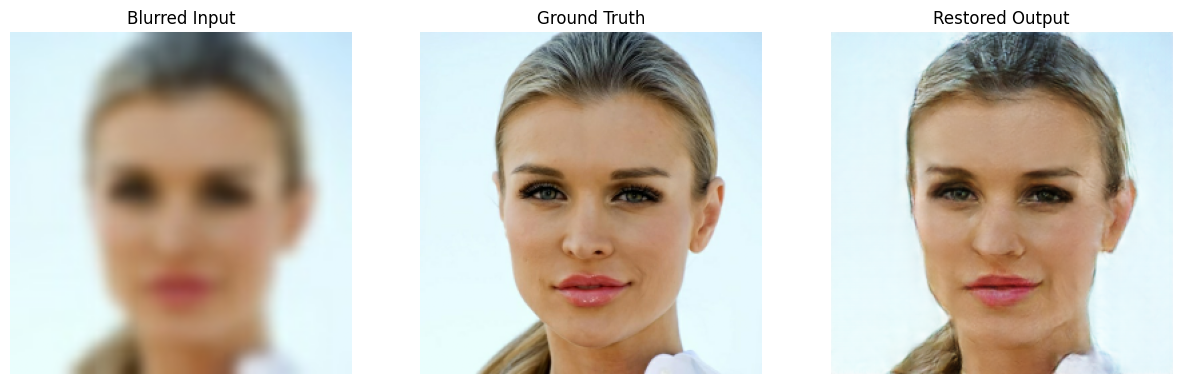

In [ ]:
# gan_evaluation_and_test.py

import os
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import random

# ==== CONFIG ====
IMG_HEIGHT = 256
IMG_WIDTH = 256
GEN_PATH = "/content/drive/MyDrive/models/generator/generator_epoch_100.keras"
DISC_PATH = "/content/drive/MyDrive/models/discriminator/discriminator_epoch_100.keras"
BLUR_PATH = "/content/drive/MyDrive/CelebAMask/lq"
CLEAR_PATH = "/content/drive/MyDrive/CelebAMask/hq"
RESTORED_OUTPUT_PATH = "/content/drive/MyDrive/restored_output.jpg"

# ==== Load Models ====
generator = tf.keras.models.load_model(GEN_PATH, compile=False)
discriminator = tf.keras.models.load_model(DISC_PATH, compile=False)
print("✅ Models loaded successfully!")

# ==== Helper: Load and Preprocess Image ====
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = (tf.cast(img, tf.float32) / 127.5) - 1
    return tf.expand_dims(img, 0)

# ==== Metric Functions ====
def calculate_psnr(y_true, y_pred):
    y_true = (y_true + 1) * 127.5
    y_pred = (y_pred + 1) * 127.5
    return tf.image.psnr(y_true, y_pred, max_val=255.0)

def calculate_ssim(y_true, y_pred):
    y_true = (y_true + 1) * 127.5
    y_pred = (y_pred + 1) * 127.5
    return tf.image.ssim(y_true, y_pred, max_val=255.0)

def calculate_accuracy(y_true, y_pred, threshold=0.1):
    diff = tf.abs(y_true - y_pred)
    correct_pixels = tf.reduce_sum(tf.cast(diff < threshold, tf.float32))
    total_pixels = tf.cast(tf.size(diff), tf.float32)
    return correct_pixels / total_pixels

# ==== Select Random Image Pair from Test Dataset ====
blurred_files = sorted([f for f in os.listdir(BLUR_PATH) if f.endswith('.jpg')])
random_file = random.choice(blurred_files)
test_blurred_path = os.path.join(BLUR_PATH, random_file)
test_clear_path = os.path.join(CLEAR_PATH, random_file)

print(f"Testing on: {random_file}")

damaged_img = load_image(test_blurred_path)
undamaged_img = load_image(test_clear_path)
restored_img = generator(damaged_img, training=False)

# ==== Calculate Metrics ====
psnr = calculate_psnr(undamaged_img, restored_img)
ssim = calculate_ssim(undamaged_img, restored_img)
accuracy = calculate_accuracy(undamaged_img, restored_img)

print(f'PSNR: {psnr.numpy()[0]:.2f} dB')
print(f'SSIM: {ssim.numpy()[0]:.4f}')
print(f'Accuracy: {accuracy.numpy()*100:.2f}%')

# ==== Show Images ====
plt.figure(figsize=(15, 5))
display_list = [damaged_img[0], undamaged_img[0], restored_img[0]]
title = ['Blurred Input', 'Ground Truth', 'Restored Output']
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow((display_list[i] + 1) / 2)
    plt.axis('off')
plt.show()


#Testing Your own input


In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

# ==== CONFIG ====
MODEL_PATH = "/content/drive/MyDrive/models/generator/generator_final.keras"
TEST_IMAGE_PATH = "/content/input.jpg"
OUTPUT_IMAGE_PATH = "/content/drive/MyDrive/models/restored_output.jpg"
IMG_SIZE = 256

# ==== LOAD MODEL ====
generator = tf.keras.models.load_model(MODEL_PATH, compile=False)
print("✅ Generator model loaded!")

# ==== PREPROCESS FUNCTION ====
def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img).astype(np.float32) / 127.5 - 1  # [-1, 1]
    return tf.expand_dims(img, axis=0)  # [1, H, W, 3]

# ==== RESTORE FUNCTION ====
def restore_image(generator, input_tensor):
    restored = generator(input_tensor, training=False)
    restored = (restored[0].numpy() + 1) * 127.5  # [0, 255]
    restored = np.clip(restored, 0, 255).astype(np.uint8)
    return Image.fromarray(restored)

# ==== DISPLAY SIDE-BY-SIDE ====
def show_comparison(input_path, output_img):
    input_img = Image.open(input_path).resize((IMG_SIZE, IMG_SIZE))
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(input_img)
    axs[0].set_title("Blurred Input")
    axs[0].axis("off")
    axs[1].imshow(output_img)
    axs[1].set_title("Restored Output")
    axs[1].axis("off")
    plt.show()

# ==== RUN ====
input_tensor = preprocess_image(TEST_IMAGE_PATH)
output_image = restore_image(generator, input_tensor)
output_image.save(OUTPUT_IMAGE_PATH)
print(f"✅ Restored image saved at: {OUTPUT_IMAGE_PATH}")

show_comparison(TEST_IMAGE_PATH, output_image)

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1
